# <b>Binary Classification with a Tabular Credit Card Fraud Dataset</b>

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import random
import gc

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: isFraud<br>
`test.csv`: 테스트 데이터 <br>

In [4]:
# LIST COLUMNS TO LOAD
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
        'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
        'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
        'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
        'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
        'M5', 'M6', 'M7', 'M8', 'M9']

# USEFUL V COLUMNS
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
cols += ['V'+str(x) for x in v]

# DECLARE COLUMN DTYPES
dtypes = {'isFraud':'int8'}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: dtypes[c] = 'float32'
for c in ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]: dtypes[c] = 'float32'

str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30',
             'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
for c in str_type: dtypes[c] = 'category'

In [5]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('train_transaction.csv', index_col='TransactionID', usecols=cols+['isFraud'], dtype=dtypes)
train_id = pd.read_csv('train_identity.csv', index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

# LOAD TEST
X_test = pd.read_csv('test_transaction.csv', index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('test_identity.csv', index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()

# PRINT STATUS
print('Train shape', X_train.shape, 'test shape', X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 30.3 s, sys: 1.58 s, total: 31.8 s
Wall time: 35.2 s


## 3. EDA & Preprocessing

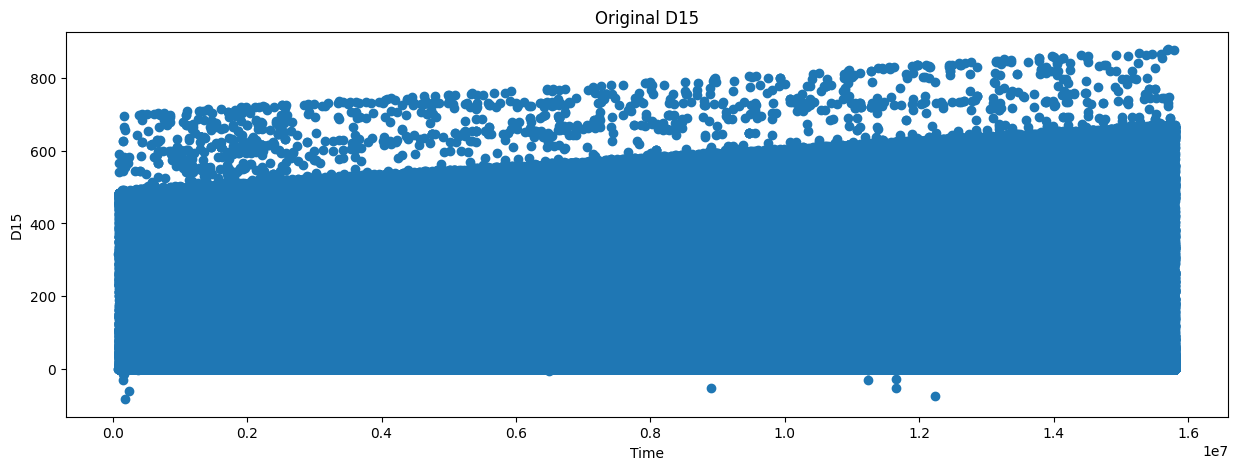

In [6]:
# PLOT ORIGINAL D15
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT, X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [7]:
%%time
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

CPU times: user 265 ms, sys: 0 ns, total: 265 ms
Wall time: 263 ms


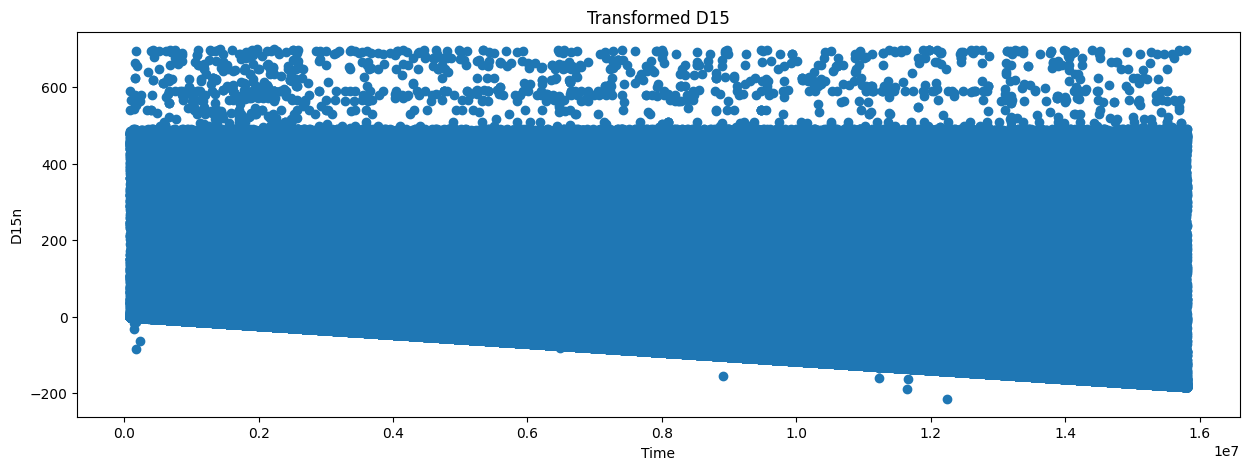

In [8]:
# PLOT TRANSFORMED D15
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT, X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [9]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'):
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 6.94 s, sys: 5.92 s, total: 12.9 s
Wall time: 12.9 s


In [10]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test,
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [11]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])

# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1', 'addr1')
encode_CB('card1_addr1', 'P_emaildomain')

# FREQUENCY ENOCDE
encode_FE(X_train, X_test, ['card1_addr1','card1_addr1_P_emaildomain'])

# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'], ['card1','card1_addr1','card1_addr1_P_emaildomain'], ['mean','std'], usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 11.4 s, sys: 5.09 s, total: 16.5 s
Wall time: 19.9 s


In [12]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [13]:
print('NOW USING THE FOLLOWING', len(cols), 'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [14]:
import datetime
# ADD MONTH FEATURE
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month

In [15]:
# ADD UID FEATURE
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [16]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train, X_test, ['uid'])
# AGGREGATE
encode_AG(['TransactionAmt', 'D4', 'D9', 'D10', 'D15'], ['uid'], ['mean', 'std'], fillna=True, usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3], ['uid'], ['mean'], X_train, X_test, fillna=True, usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)], ['uid'], ['mean'], fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'], ['uid'], ['std'], X_train, X_test, fillna=True, usena=True)
# AGGREGATE
encode_AG2(['C13', 'V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)

# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 1min 48s, sys: 17.1 s, total: 2min 5s
Wall time: 2min 8s


In [17]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

## 4. Train Model
- 평가지표: `area under the ROC curve(AUC)`

###  4-1. Train XGBoost Model

In [18]:
# CHRIS - TRAIN 75%, PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [19]:
BUILD96 = True

In [20]:
if BUILD96:
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        tree_method='gpu_hist' # USE GPU
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT],
        eval_set=[(X_train.loc[idxV,cols], y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.82742
[50]	validation_0-auc:0.87681
[100]	validation_0-auc:0.89108
[150]	validation_0-auc:0.90588
[200]	validation_0-auc:0.91832
[250]	validation_0-auc:0.92557
[300]	validation_0-auc:0.93046
[350]	validation_0-auc:0.93371
[400]	validation_0-auc:0.93550
[450]	validation_0-auc:0.93639
[500]	validation_0-auc:0.93688
[550]	validation_0-auc:0.93677
[600]	validation_0-auc:0.93693
[650]	validation_0-auc:0.93648
[675]	validation_0-auc:0.93637


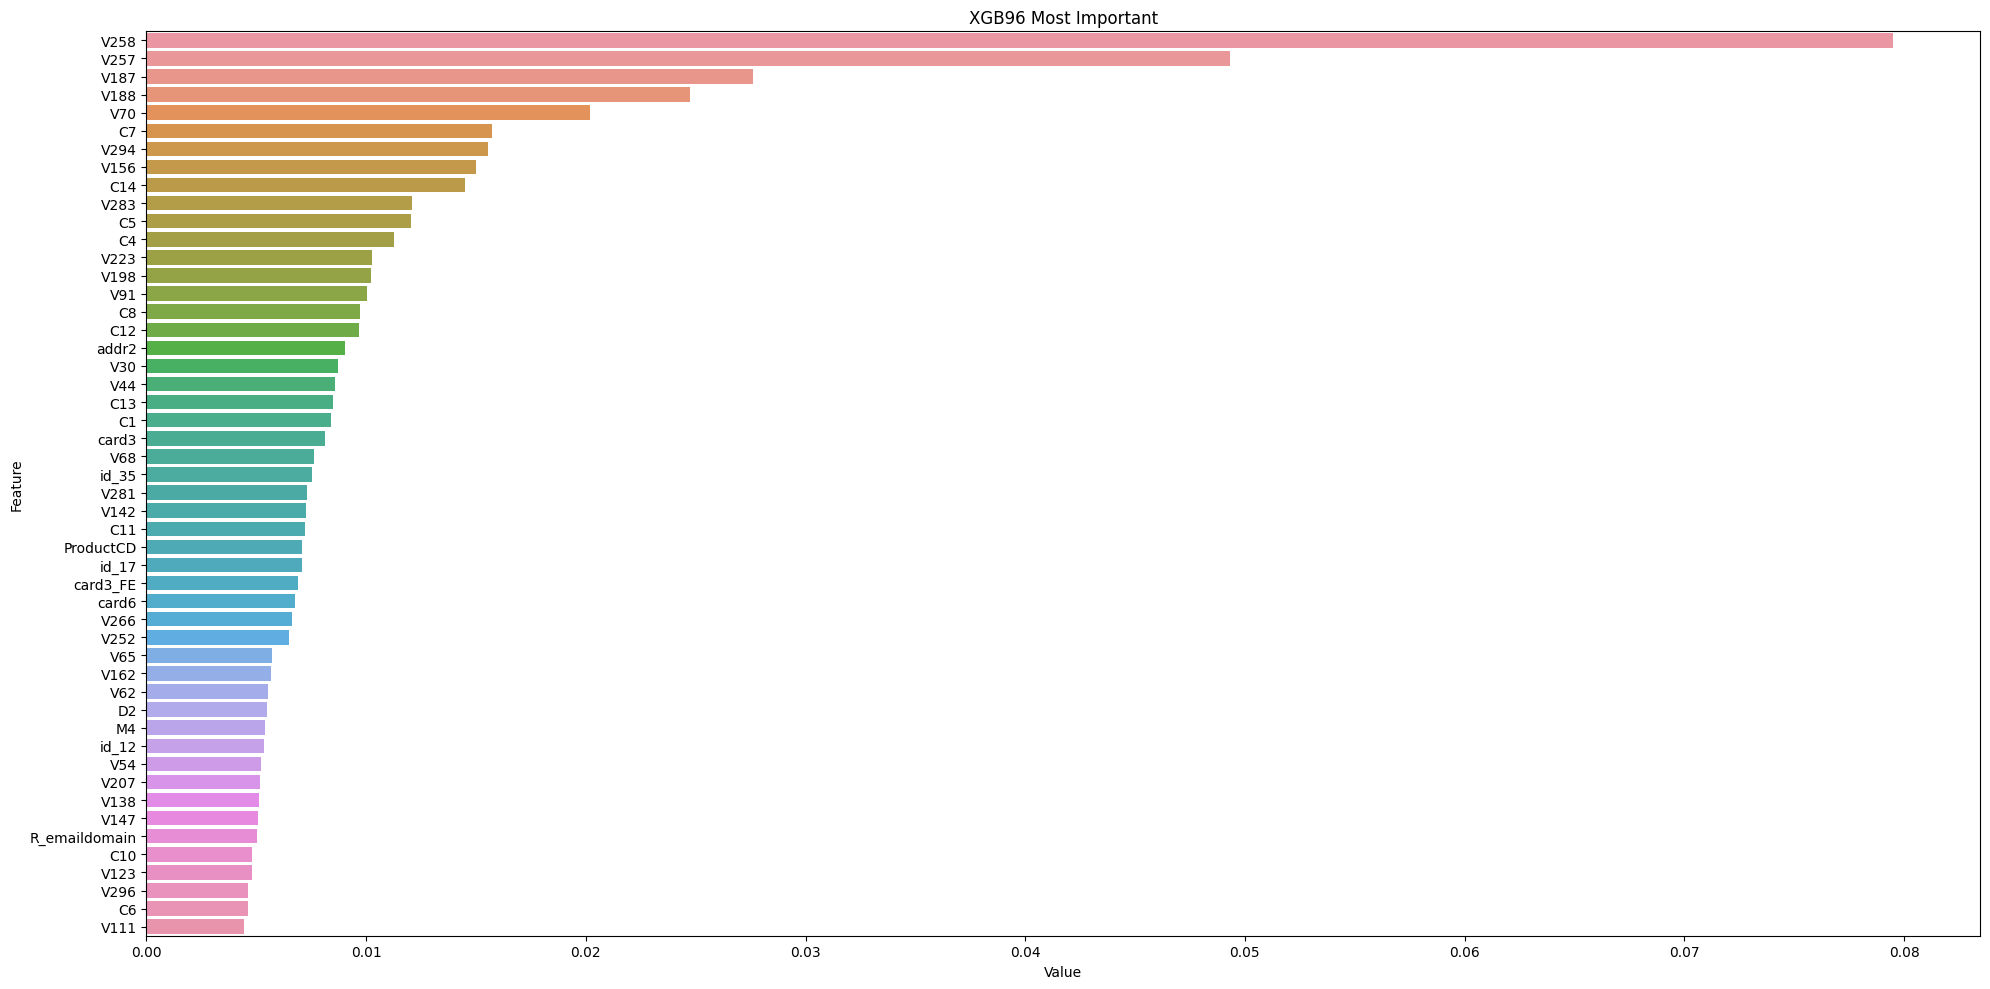

In [21]:
if BUILD96:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value', 'Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()

    del clf, h; x = gc.collect()

In [22]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            tree_method='gpu_hist' # USE GPU
        )
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)

        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x = gc.collect()
    print('='*30)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.80461
[100]	validation_0-auc:0.87094
[200]	validation_0-auc:0.89238
[300]	validation_0-auc:0.90346
[400]	validation_0-auc:0.90640
[500]	validation_0-auc:0.90943
[600]	validation_0-auc:0.91004
[700]	validation_0-auc:0.91013
[800]	validation_0-auc:0.90904
[847]	validation_0-auc:0.90890
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.84448
[100]	validation_0-auc:0.90541
[200]	validation_0-auc:0.92928
[300]	validation_0-auc:0.94140
[400]	validation_0-auc:0.94546
[500]	validation_0-auc:0.94696
[600]	validation_0-auc:0.94734
[700]	validation_0-auc:0.94732
[800]	validation_0-auc:0.94710
[830]	validation_0-auc:0.94711
Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
[0]	validation_0-auc:0.84497
[100]	validation_0-auc:0.90235
[200]	validation_0-auc:0.92290
[300]	validation_0-auc:0.93557
[400]	validation_0-auc:0.94036
[

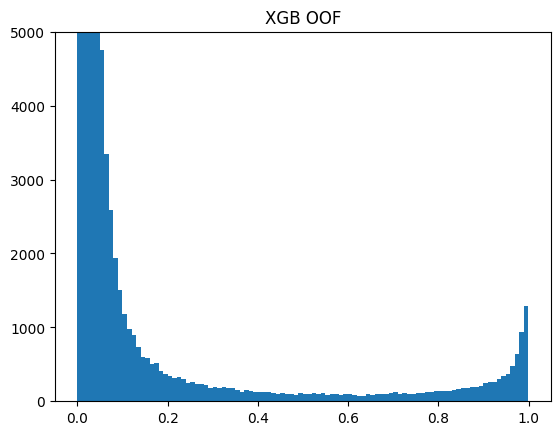

In [23]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID', 'oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID', drop=True, inplace=True)

## 5. Submission

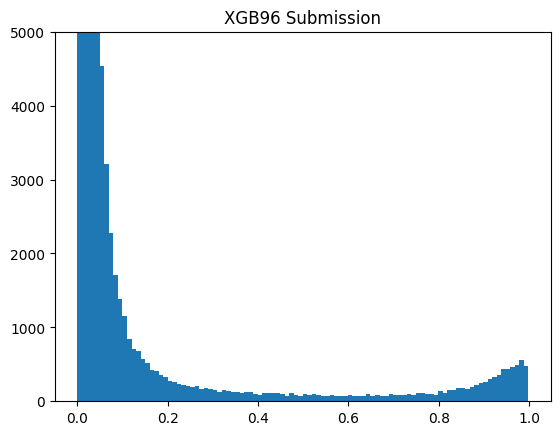

In [24]:
if BUILD96:
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('submission.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB96 Submission')
    plt.show()